# Spark MLlib: Aprendizaje Supervisado

## Omar Gaston - oy-gastonc@javeriana.edu.co

#### Pontificia Universidad Javeriana (PUJ) | *Computacion de alto redimiento* 

- **Docente:** John Jairo Corredor Franco
-  
**Tema:** Clustering con Spark MLlib
---

Este cuaderno muestra cómo:

1. Cargar y explorar un conjunto de datos
2. Preparar datos para el aprendizaje automático
3. Entrenar dos modelos de aprendizaje supervisado diferentes
4. Evaluar y comparar el rendimiento de los modelos

#### Objetivo
Aplicar técnicas de aprendizaje supervisado usando Spark MLlib para clasificacion de vinos.

**Modelos**: Regresión logística vs. Clasificador de bosque aleatorio

**Conjunto de datos**: Calidad de vinos

---

## Contexto del Problema

### Predicción de Calidad del Vino

Para este ejemplo vamos a evaluar de manera objetiva la calidad del vino. Tradicionalmente, esto requiere expertos, pero en este caso vamos a usar Machine Learning para predecir la calidad basándonos en propiedades químicas medibles.

### El Dataset: Vinho Verde de Portugal

Este dataset contiene **1,599 muestras de vino tinto** con 11 características químicas:

| Característica | Descripción | Impacto en Sabor |
|---------------|-------------|------------------|
| `fixed acidity` | Ácidos no volátiles (tartárico) | Frescura, estructura |
| `volatile acidity` | Ácidos volátiles (acético) | En exceso: sabor a vinagre |
| `citric acid` | Ácido cítrico | Frescura, notas cítricas |
| `residual sugar` | Azúcar residual después de fermentación | Dulzor |
| `chlorides` | Sal | Salinidad |
| `free/total sulfur dioxide` | Conservantes | Protección contra oxidación |
| `density` | Densidad del líquido | Correlacionada con alcohol y azúcar |
| `pH` | Acidez/alcalinidad | Balance, estabilidad |
| `sulphates` | Aditivo | Contribuye a SO2, sabor |
| `alcohol` | Contenido alcohólico | Cuerpo, calidez |

### Nuestro Enfoque

Convertiremos el problema de **regresión multiclase** (calidad 3-8) a **clasificación binaria**:
- **Buena calidad**: puntuación ≥ 6
- **Mala calidad**: puntuación < 6

Esto simplifica el problema y permite comparar modelos de clasificación directamente.

### Algoritmos a Comparar

| Algoritmo | Enfoque | 
|-----------|---------|
| **Regresion Logistica** | Frontera linear |
| **Random Forest** | Arbol de desicion |


## 2. Marco Teórico

### 2.1 Clasificación

Es una rama del aprendizaje supervisado enfocada en predecir categorías discretas:

- Binaria (ej: sí/no)
- Multiclase (ej: baja, media, alta)

Los modelos aprenden patrones que separan clases usando relaciones entre variables.

### 2.2 Apache Spark MLlib

Apache Spark MLlib es la biblioteca de aprendizaje automático escalable de Spark.

### 2.3 Referencias Teóricas

1. **Hastie, Tibshirani, & Friedman (2009)**. The Elements of Statistical Learning. Springer.

2. **James et al. (2013)**. An Introduction to Statistical Learning. Springer.

---


## 3. Configuración del Entorno

### 3.1 Requisitos del Sistema

| Componente | Requisito |
|------------|-----------|
| **Python** | >= 3.8 |
| **Apache Spark** | >= 3.0.0 |
| **Memoria RAM** | >= 4 GB |
| **CPU Cores** | >= 4 cores (recomendado) |
| **Sistema Operativo** | Linux |

### 3.2 Dependencias

Instalamos los paquetes necesarios, agregando `%%capture` para no mostrar el output en el notebook. Luego ignoramos los `warning` emitidos por python y finalmente inicializamos spark.

In [2]:
%%capture
!pip install findspark
!pip install pandas numpy matplotlib seaborn

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Bibliotecas de PySpark MLlib y la inicializacion para la sesion.

import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

### 3.1. Iniciar la sesión de Spark Session

Para este cuaderno utilizaremos una configuracion de spark que nos permita utilizar hacer una ejecucion optima para este experimento.

In [5]:
# Importar librerias necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd

sparkConf = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.shuffle.io.maxRetries", "10")
        .set("spark.shuffle.io.retryWait", "60s") 
        .set("spark.cores.max", "4")
        .set("spark.driver.memory", "4g")
        .set("spark.network.timeout", "600s") 
        .set("spark.driver.host", "10.43.100.120")
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.driver.port", "36843")
        .set("spark.blockManager.port", "37000")
        .set("spark.executor.extraClassPath", "/opt/spark/jars/*")
        .set("spark.executor.heartbeatInterval", "60s")
        .setMaster("spark://10.43.100.121:7077")
)

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Omar MLib Supervisado") \
    .config(conf=sparkConf) \
    .getOrCreate()

SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
# Ocultar warnings
spark.sparkContext.setLogLevel("ERROR")

print(f"Spark Version: {spark.version}")
print("Spark Session creada exitosamente!")

Spark Version: 3.5.2
Spark Session creada exitosamente!


---

## 4. Cargar y explorar el Dataset

Descargaremos el dataset y lo ubicaremos en una ruta compartida del cluster de spark

In [7]:
import urllib.request

# Descargar
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
local_path = "/nfs/condor/winequality-red.csv"

print("Descargando dataset...")
urllib.request.urlretrieve(url, local_path)
print("Descarga completa!")

# Leer CSV
df = spark.read.csv(
    local_path,
    header=True,
    inferSchema=True,
    sep=";"
)

# Guardar la columna quality para análisis posterior
df = df.withColumnRenamed("quality", "true_quality")

print("\nDataset cargado exitosamente!")
print(f"Total: {df.count()}")
print(f"\nSchema:")
df.printSchema()

Descargando dataset...
Descarga completa!

Dataset cargado exitosamente!
Total: 1599

Schema:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- true_quality: integer (nullable = true)



## 5. Preparacion de Features

### Ingeniería de Características

**¿Por qué convertir a clasificación binaria?**
La distribución original de calidad muestra un problema común en ML, las clases no se encuentran balanceadas.
Las clases extremas (3, 4, 8) tienen muy pocos ejemplos para entrenar un modelo confiable.

**VectorAssembler: El Puente hacia MLlib**
MLlib requiere que todas las características estén en un único vector denso. `VectorAssembler` transforma:

```
Antes:  [col1=7.4, col2=0.7, col3=0.0, ...]
Después: features=[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
```


In [6]:
from pyspark.sql.functions import when


# Convertir a binarios: 
# Si quality >= 6 es "good" (1), de lo contratrario "bad" (0)
df = df.withColumn('label', when(df['label'] >= 6, 1).otherwise(0))

print("Distribucion de etiquetas:")
df.groupBy('label').count().show()

# Definir columnas de características
feature_cols = [col for col in df.columns if col not in ['quality', 'label']]

print(f"Características: {feature_cols}")
print(f"Número de características: {len(feature_cols)}")

# Mostrar
df.show(5)

Distribucion de etiquetas:
+-----+-----+
|label|count|
+-----+-----+
|    1|  855|
|    0|  744|
+-----+-----+

Características: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Número de características: 11
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    0|
|          7.8|            0.88|        0.0|           2.6|    0.098|        

In [7]:
print("Distribucion (Wine Quality Ratings):")
df.groupBy('label').count().orderBy('label').show()

Distribucion (Wine Quality Ratings):
+-----+-----+
|label|count|
+-----+-----+
|    0|  744|
|    1|  855|
+-----+-----+



In [17]:
# Ensamblar dataset
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

df_assembled = assembler.transform(df)

print("Feature vector created:")
df_assembled.select('features', 'label').show(5, truncate=False)

Feature vector created:
+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |0    |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |0    |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |0    |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|1    |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |0    |
+--------------------------------------------------------+-----+
only showing top 5 rows



## 6. Dividir la data en Train y Test

### División Train/Test

**¿Por qué 70/30?**

Esta proporción es un estándar en ML cuando el dataset es de tamaño moderado. Se podria agregar una porcion de *cross-validation*, pero esto sale del scope de este ejercicio. 

**Verificación de estratificación:**

Observa que la distribución de clases es similar en ambos conjuntos. Esto es crucial porque:
- Si el training tuviera 90% buena calidad y el test 50%, el modelo estaría sesgado
- `randomSplit` con una semilla fija (`seed=42`) garantiza reproducibilidad


In [18]:
# Divicion de la data: 70% training, 30% testing
train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)

print(f"Training set: {train_data.count()}")
print(f"Test set: {test_data.count()}")

print("\nDistribucion de clases en Training set:")
train_data.groupBy('label').count().show()

print("Distribucion de clases en Testing set:")
test_data.groupBy('label').count().show()

Training set: 1173
Test set: 426

Distribucion de clases en Training set:
+-----+-----+
|label|count|
+-----+-----+
|    1|  636|
|    0|  537|
+-----+-----+

Distribucion de clases en Testing set:
+-----+-----+
|label|count|
+-----+-----+
|    1|  219|
|    0|  207|
+-----+-----+



## 7. Entrenamiento de modelos

### 7.1 Modelo 1: Regresion logistica

### Regresion logistica

**Funcionamiento**: Modela la probabilidad de pertenencia a una clase usando la función sigmoide:

**Hiperparámetros clave:**
- `maxIter=100`: Número máximo de iteraciones del optimizador
- `regParam=0.01`: Regularización L2 para prevenir overfitting
- `elasticNetParam=0.0`: Sin regularización L1 (solo L2)

**Ventajas:**
- Interpretable (coeficientes indican importancia de cada feature)
- Rápido de entrenar

**Desventajas:**
- Asume relación lineal entre features y log-odds
- Puede sufrir con features altamente correlacionadas

---

In [19]:
lr = LogisticRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0
)

print("Logistic Regression model inicializado")
print(f"Parameters: maxIter={lr.getMaxIter()}, regParam={lr.getRegParam()}")

Logistic Regression model inicializado
Parameters: maxIter=100, regParam=0.01


In [20]:
# Entrenar
print("Entrenando Logistic Regression model...")
lr_model = lr.fit(train_data)
print("Completado!")

# Display coefficients
print(f"\Clases: {lr_model.numClasses}")
print(f" Features: {lr_model.numFeatures}")

Entrenando Logistic Regression model...
Completado!
\Clases: 2
 Features: 11


In [21]:
# Hacer predicciones en datos de prueba
lr_predictions = lr_model.transform(test_data)

print("Muestra de predicciones:")
lr_predictions.select('features', 'label', 'prediction', 'probability').show(5, truncate=False)

Muestra de predicciones:
+---------------------------------------------------------+-----+----------+-----------------------------------------+
|features                                                 |label|prediction|probability                              |
+---------------------------------------------------------+-----+----------+-----------------------------------------+
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|1    |1.0       |[0.021071379040579388,0.9789286209594206]|
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]|1    |1.0       |[0.23344961237421855,0.7665503876257814] |
|[5.0,1.04,0.24,1.6,0.05,32.0,96.0,0.9934,3.74,0.62,11.5] |0    |0.0       |[0.7473590285943412,0.2526409714056588]  |
|[5.1,0.42,0.0,1.8,0.044,18.0,88.0,0.99157,3.68,0.73,13.6]|1    |1.0       |[0.05288581282039355,0.9471141871796065] |
|[5.2,0.32,0.25,1.8,0.103,13.0,50.0,0.9957,3.38,0.55,9.2] |0    |0.0       |[0.7255809589000628,0.2744190410999372]  |
+----------------------

### 7.2 Modelo 2: Random Forest

#### Random Forest

**Funcionamiento**: Ensemble de múltiples árboles de decisión que votan la predicción final.

**Hiperparámetros clave:**
- `numTrees=100`: Número de árboles en el bosque
- `maxDepth=5`: Profundidad máxima de cada árbol

**Ventajas:**
- Captura relaciones no lineales automáticamente
- Proporciona importancia de features

**Desventajas:**
- Más lento de entrenar
- Puede hacer overfitting si `maxDepth` es muy alto


In [22]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=100,
    maxDepth=5,
    seed=42
)

print("Clasificador RF inicializado")
print(f"Parámetros: numTrees={rf.getNumTrees()}, maxDepth={rf.getMaxDepth()}")

Clasificador RF inicializado
Parámetros: numTrees=100, maxDepth=5


In [23]:
print("Entrenando modelo de Random Forest...")
rf_model = rf.fit(train_data)
print("¡Entrenamiento completado!")

# Mostrar importancia de características
print("\nImportancia de Características:")
for idx, importance in enumerate(rf_model.featureImportances):
    print(f"{feature_cols[idx]}: {importance:.4f}")

Entrenando modelo de Random Forest...
¡Entrenamiento completado!

Importancia de Características:
fixed acidity: 0.0374
volatile acidity: 0.1310
citric acid: 0.0347
residual sugar: 0.0223
chlorides: 0.0368
free sulfur dioxide: 0.0210
total sulfur dioxide: 0.0855
density: 0.0682
pH: 0.0302
sulphates: 0.1641
alcohol: 0.3688


In [24]:
# Hacer predicciones en datos de prueba
rf_predictions = rf_model.transform(test_data)

print("Muestra de predicciones:")
rf_predictions.select('features', 'label', 'prediction', 'probability').show(5, truncate=False)

Muestra de predicciones:
+---------------------------------------------------------+-----+----------+----------------------------------------+
|features                                                 |label|prediction|probability                             |
+---------------------------------------------------------+-----+----------+----------------------------------------+
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|1    |1.0       |[0.11952539851586506,0.8804746014841349]|
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]|1    |1.0       |[0.2339323196782643,0.7660676803217357] |
|[5.0,1.04,0.24,1.6,0.05,32.0,96.0,0.9934,3.74,0.62,11.5] |0    |1.0       |[0.2982549862701638,0.7017450137298362] |
|[5.1,0.42,0.0,1.8,0.044,18.0,88.0,0.99157,3.68,0.73,13.6]|1    |1.0       |[0.11864102307960912,0.8813589769203908]|
|[5.2,0.32,0.25,1.8,0.103,13.0,50.0,0.9957,3.38,0.55,9.2] |0    |0.0       |[0.7228949270865354,0.27710507291346465]|
+------------------------------

## 6. Evaluación y Comparación de Modelos

### Métricas de Evaluación

- Accuracy (Exactitud)
- Precision (Precisión)
- Recall (Sensibilidad)
- F1 Score
- Matriz de Confusión

**Insight del negocio**: En vinos, un **Falso Positivo** (vender vino malo como bueno) es más costoso que un **Falso Negativo** (rechazar vino bueno). Por lo tanto, debemos priorizar **Precision** sobre Recall.


In [25]:
# Inicializar evaluadores
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='f1'
)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedPrecision'
)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='weightedRecall'
)

In [26]:
# Evaluar Regresión Logística
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)
lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)

print("=" * 50)
print("RENDIMIENTO DE REGRESIÓN LOGÍSTICA")
print("=" * 50)
print(f"Exactitud (Accuracy):  {lr_accuracy:.4f}")
print(f"F1 Score:              {lr_f1:.4f}")
print(f"Precisión:             {lr_precision:.4f}")
print(f"Recall:                {lr_recall:.4f}")

RENDIMIENTO DE REGRESIÓN LOGÍSTICA
Exactitud (Accuracy):  0.7512
F1 Score:              0.7512
Precisión:             0.7514
Recall:                0.7512


In [27]:
# Evaluar Random Forest
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)

print("=" * 50)
print("RENDIMIENTO DE RANDOM FOREST")
print("=" * 50)
print(f"Exactitud (Accuracy):  {rf_accuracy:.4f}")
print(f"F1 Score:              {rf_f1:.4f}")
print(f"Precisión:             {rf_precision:.4f}")
print(f"Recall:                {rf_recall:.4f}")

RENDIMIENTO DE RANDOM FOREST
Exactitud (Accuracy):  0.7582
F1 Score:              0.7577
Precisión:             0.7590
Recall:                0.7582


### 6.1 Matriz de confusion

In [28]:
# Función para crear matriz de confusión
def create_confusion_matrix(predictions):
    confusion = predictions.groupBy('label', 'prediction').count()
    return confusion.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

# Matriz de Confusión de Regresión Logística
print("Matriz de Confusión - Regresión Logística:")
lr_cm = create_confusion_matrix(lr_predictions)
print(lr_cm)
print("\nFilas = Etiquetas Reales, Columnas = Predicciones")

print("\n" + "=" * 50)

# Matriz de Confusión de Random Forest
print("Matriz de Confusión - Random Forest:")
rf_cm = create_confusion_matrix(rf_predictions)
print(rf_cm)
print("\nFilas = Etiquetas Reales, Columnas = Predicciones")

Matriz de Confusión - Regresión Logística:
prediction  0.0  1.0
label               
0           156   51
1            55  164

Filas = Etiquetas Reales, Columnas = Predicciones

Matriz de Confusión - Random Forest:
prediction  0.0  1.0
label               
0           148   59
1            44  175

Filas = Etiquetas Reales, Columnas = Predicciones


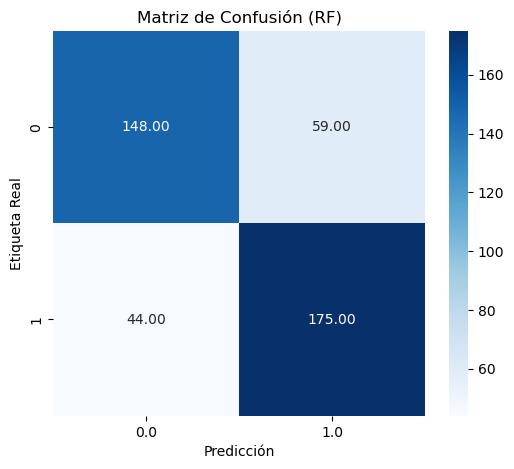

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Obtener matriz de confusión desde Spark ---

# Contar cada combinación (label, prediction)
cm_spark = (
    rf_predictions.groupBy("label", "prediction")
    .count()
    .toPandas()
)

# Crear tabla pivoteada (label vs prediction)
cm = cm_spark.pivot_table(
    index="label",
    columns="prediction",
    values="count",
    fill_value=0
)
# 2. Graficar 

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Confusión (RF)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


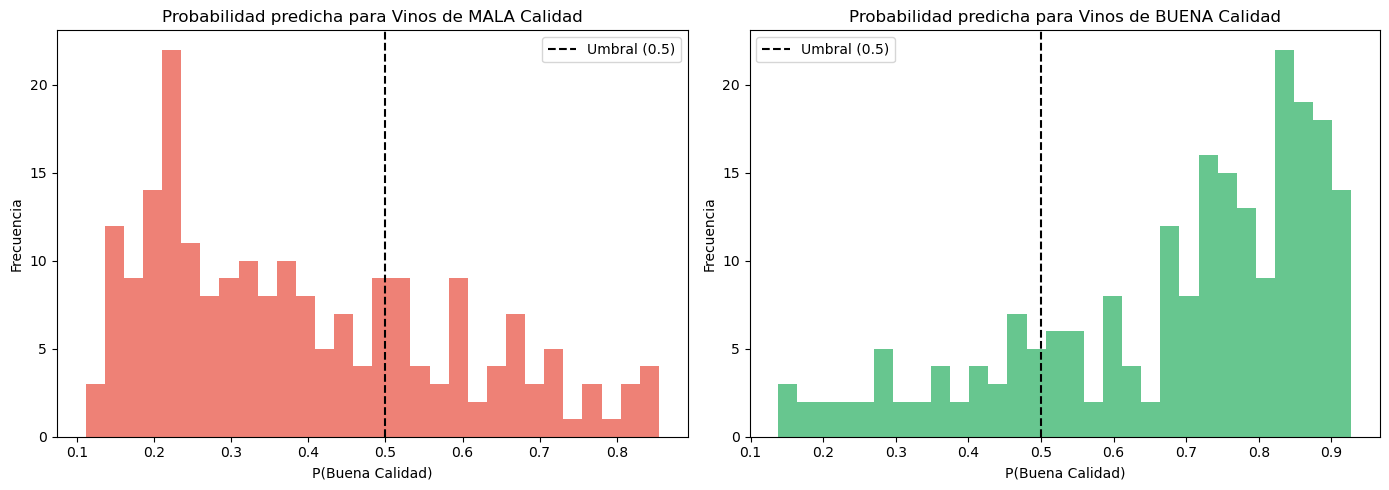

In [30]:
# Extraer probabilidades
probs_pd = rf_predictions.select('label', 'probability').toPandas()
probs_pd['prob_good'] = probs_pd['probability'].apply(lambda x: float(x[1]))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución para clase 0 (mala calidad)
axes[0].hist(probs_pd[probs_pd['label'] == 0]['prob_good'], bins=30, color='#e74c3c', alpha=0.7)
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Umbral (0.5)')
axes[0].set_title('Probabilidad predicha para Vinos de MALA Calidad')
axes[0].set_xlabel('P(Buena Calidad)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Distribución para clase 1 (buena calidad)
axes[1].hist(probs_pd[probs_pd['label'] == 1]['prob_good'], bins=30, color='#27ae60', alpha=0.7)
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Umbral (0.5)')
axes[1].set_title('Probabilidad predicha para Vinos de BUENA Calidad')
axes[1].set_xlabel('P(Buena Calidad)')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()

plt.tight_layout()
plt.show()

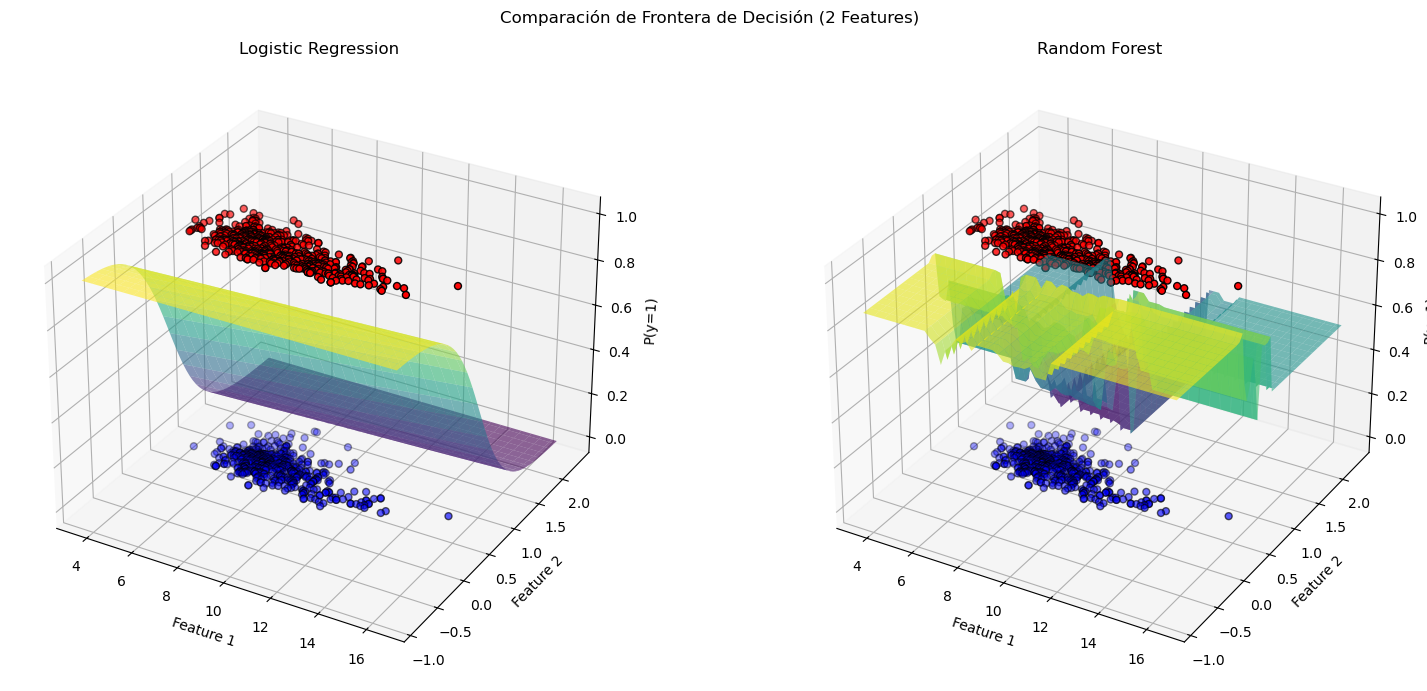

In [36]:
from pyspark.ml.feature import VectorSlicer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Seleccionar dos features
slicer = VectorSlicer(
    inputCol="features",
    outputCol="features_2d",
    indices=[0, 1]
)

df_2d = slicer.transform(train_data)

# 2. Entrenar Logistic Regression
lr_2d = LogisticRegression(
    featuresCol="features_2d",
    labelCol="label",
    maxIter=100,
    regParam=0.01
)
model_lr = lr_2d.fit(df_2d)

# 3. Entrenar Random Forest
rf_2d = RandomForestClassifier(
    featuresCol="features_2d",
    labelCol="label",
    numTrees=50,
    maxDepth=5,
    seed=42
)
model_rf = rf_2d.fit(df_2d)

# 4. Datos a Pandas
pdf = df_2d.select("features_2d", "label").toPandas()

X = np.array(pdf["features_2d"].tolist())
y = pdf["label"].values

x1, x2 = X[:,0], X[:,1]

x_min, x_max = x1.min()-1, x1.max()+1
y_min, y_max = x2.min()-1, x2.max()+1

# 5. Malla
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 60),
    np.linspace(y_min, y_max, 60)
)

grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=["f1", "f2"])
spark_grid = spark.createDataFrame(grid, ["f1", "f2"])

assembler = VectorAssembler(inputCols=["f1", "f2"], outputCol="features_2d")
spark_grid = assembler.transform(spark_grid)

# 6. Predicciones
pred_lr = model_lr.transform(spark_grid).select("probability").toPandas()
pred_rf = model_rf.transform(spark_grid).select("probability").toPandas()

Z_lr = pred_lr["probability"].apply(lambda v: v[1]).values.reshape(xx.shape)
Z_rf = pred_rf["probability"].apply(lambda v: v[1]).values.reshape(xx.shape)

# 7. Gráficas 3D
fig = plt.figure(figsize=(16,7))

# Logistic Regression
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(xx, yy, Z_lr, cmap="viridis", alpha=0.6)
ax1.scatter(x1, x2, y, c=y, cmap="bwr", edgecolor="k", s=25)
ax1.set_title("Logistic Regression")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("P(y=1)")

# Random Forest
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(xx, yy, Z_rf, cmap="viridis", alpha=0.6)
ax2.scatter(x1, x2, y, c=y, cmap="bwr", edgecolor="k", s=25)
ax2.set_title("Random Forest")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_zlabel("P(y=1)")

plt.suptitle("Comparación de Frontera de Decisión (2 Features)")
plt.tight_layout()
plt.show()


### Analisis de los graficos

- La regresión logística genera una frontera suave por su naturaleza lineal.

- Random Forest produce fronteras no lineales por división basada en árboles.


## Resumen del analisis

Con este cuaderno se demostró el uso de Spark para entrenamiento y evaluacion de modelos supervisados, siguiendo los siguientes pasos:

1. **Carga de Datos**: Se cargó el conjunto de datos Wine Quality y se convirtió a DataFrame de Spark
2. **Preprocesamiento**: Se convirtió el problema a clasificación binaria (bueno vs. malo) y se ensamblaron las características
3. **División Train-Test**: Se dividieron los datos en 70% entrenamiento y 30% prueba
4. **Entrenamiento de Modelos**: Se entrenaron modelos de Regresión Logística y Random Forest
5. **Evaluación**: Se compararon los modelos usando exactitud, F1 score, precisión y recall
6. **Análisis**: Se generaron matrices de confusión y se analizaron predicciones incorrectas

### Principales Conclusiones:

- El **Dataset** contiene 1,599 muestras de vino tinto con 11 características químicas, el cual se destribuye entre los worker durante el manejo de datos.
- Se tomo un **problema de clasificación binaria** para la calidad del vino (buena vs. mala calidad) ya que con este se podria utilizar de manera facil un modelo de regresion logistica y hacer comparaciones. 
- El modelo de **Regresión Logística** tiende a ser lineal simple, mas interpretable y con un buen rendimiento base
- Mientras que el **modelo RF**, captura relaciones no lineales, generalmente mejor rendimiento.
- Random Forest identifica qué características químicas son más importantes para predecir la calidad, lo cual lo hace mas flexible para datasets cambiantes. 